## Exercise4

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-02-24 23:11:18--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.04s   

2021-02-24 23:11:18 (1.54 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



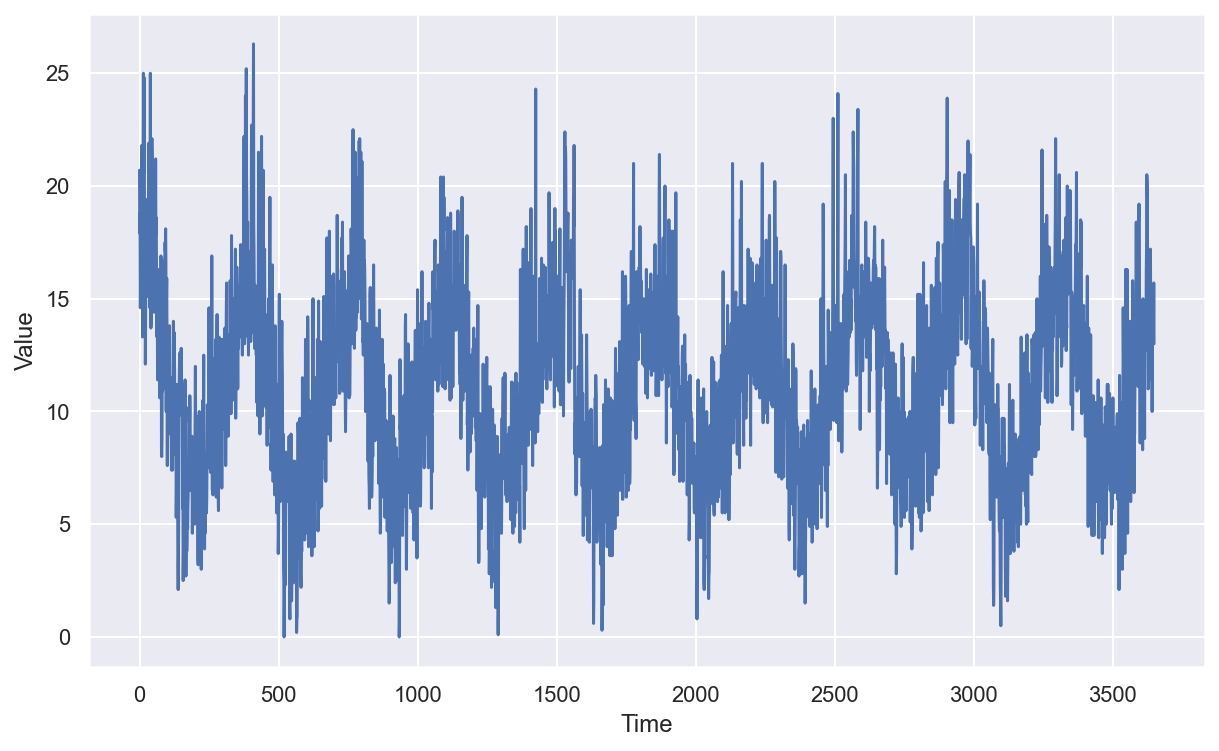

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step=step+1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 6s 180ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 2s 205ms/step - loss: 30.7697 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 2s 169ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 2s 188ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 2s 177ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 2s 195ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 3s 251ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 3s 237ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 2s 231ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10/

10/10 [==============================] - 2s 165ms/step - loss: 4.8170 - mae: 5.3045
Epoch 85/100
10/10 [==============================] - 2s 161ms/step - loss: 5.6331 - mae: 6.1238
Epoch 86/100
10/10 [==============================] - 2s 161ms/step - loss: 7.2330 - mae: 7.7282
Epoch 87/100
10/10 [==============================] - 2s 157ms/step - loss: 7.1601 - mae: 7.6513
Epoch 88/100
10/10 [==============================] - 2s 178ms/step - loss: 21.2826 - mae: 21.7797
Epoch 89/100
10/10 [==============================] - 2s 180ms/step - loss: 31.7534 - mae: 32.2517
Epoch 90/100
10/10 [==============================] - 2s 215ms/step - loss: 45.1093 - mae: 45.6064
Epoch 91/100
10/10 [==============================] - 3s 229ms/step - loss: 58.7745 - mae: 59.2745
Epoch 92/100
10/10 [==============================] - 3s 235ms/step - loss: 55.7196 - mae: 56.2196
Epoch 93/100
10/10 [==============================] - 2s 173ms/step - loss: 54.7029 - mae: 55.2029
Epoch 94/100
10/10 [===========

(1e-08, 0.0001, 0.0, 60.0)

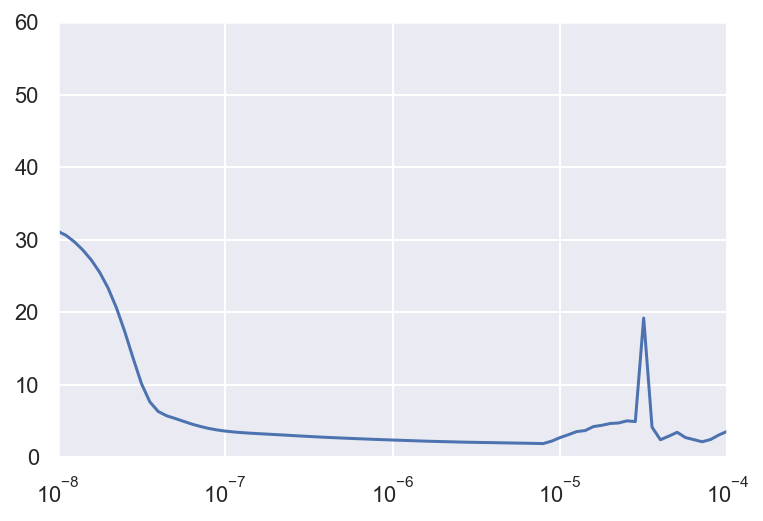

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 6s 71ms/step - loss: 15.8473 - mae: 16.3396
Epoch 2/150
25/25 [==============================] - 2s 71ms/step - loss: 2.9314 - mae: 3.3996
Epoch 3/150
25/25 [==============================] - 2s 64ms/step - loss: 2.0152 - mae: 2.4714
Epoch 4/150
25/25 [==============================] - 2s 62ms/step - loss: 1.9115 - mae: 2.3666
Epoch 5/150
25/25 [==============================] - 2s 64ms/step - loss: 1.8753 - mae: 2.3297
Epoch 6/150
25/25 [==============================] - 2s 73ms/step - loss: 1.8384 - mae: 2.2916
Epoch 7/150
25/25 [==============================] - 2s 67ms/step - loss: 1.8145 - mae: 2.2668
Epoch 8/150
25/25 [==============================] - 2s 75ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 2s 68ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 2s 63ms/step - loss: 1.7410 - mae: 2.1911
Epoch 11/150
25/25 [===========================

25/25 [==============================] - 2s 59ms/step - loss: 1.5327 - mae: 1.9751
Epoch 87/150
25/25 [==============================] - 2s 61ms/step - loss: 1.5347 - mae: 1.9767
Epoch 88/150
25/25 [==============================] - 2s 81ms/step - loss: 1.5338 - mae: 1.9758
Epoch 89/150
25/25 [==============================] - 2s 68ms/step - loss: 1.5299 - mae: 1.9721
Epoch 90/150
25/25 [==============================] - 2s 64ms/step - loss: 1.5380 - mae: 1.9804
Epoch 91/150
25/25 [==============================] - 2s 58ms/step - loss: 1.5291 - mae: 1.9712
Epoch 92/150
25/25 [==============================] - 2s 58ms/step - loss: 1.5300 - mae: 1.9723
Epoch 93/150
25/25 [==============================] - 2s 59ms/step - loss: 1.5270 - mae: 1.9691
Epoch 94/150
25/25 [==============================] - 2s 57ms/step - loss: 1.5341 - mae: 1.9768
Epoch 95/150
25/25 [==============================] - 2s 58ms/step - loss: 1.5334 - mae: 1.9763
Epoch 96/150
25/25 [==============================] -

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

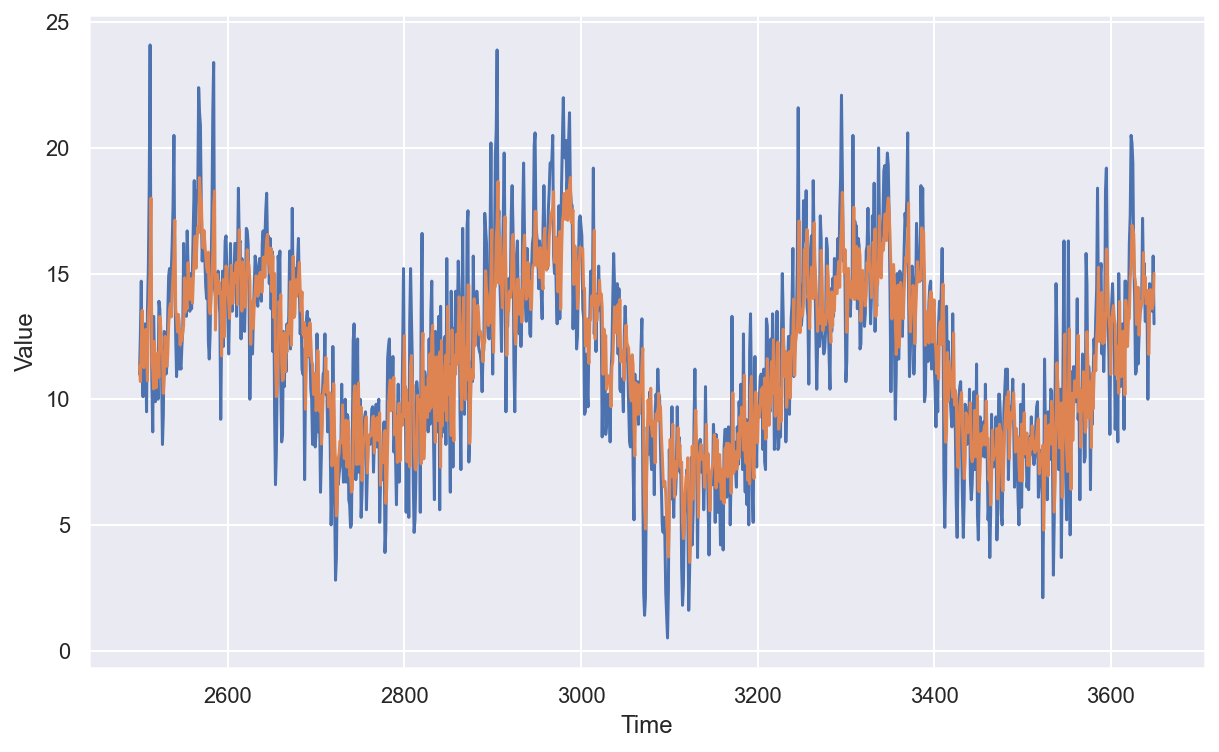

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7796171

In [14]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.329711 10.705763 12.125129 ... 13.604885 13.797191 15.009674]
